In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics
from operator import sub, mul, pow

In [48]:
df = pd.read_csv("Fife-data/flex_networks.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"], infer_datetime_format=True)
loads = np.asarray(df["crawfordCrescent_F2"])

In [41]:
def Norm4_Diff(a, b):
    return (a**4 + b**4) ** (1/4)

In [67]:
h = 48
d = 160
N = 10
F_i = np.zeros((48,N))
G_i = np.zeros((48,N))
Gbar_i = np.zeros((48,N))
F_1 = np.zeros(48)

for j in range(48):
    F_1[j] = statistics.median(loads[h*(d-N)+j : d*h+j : h])   # Gives d+1

for i in range(N):
    G_i[:,i] = loads[h*(d-(7*i+7)):h*(d-(7*i+6))]

    for j in range(48):
       
        Gbar_i[j,i] = Norm4_Diff(F_i[j,i], G_i[j,i])
    
    for j in range(i+1):
        F_i[:,i] += (F_1 + Gbar_i[:,j])
    print(F_i[:,i])
    F_i[:,i] = F_i[:,i] * (1/(i+2))








[ 7.15408333  6.72103333  6.79855     6.6208      6.7049      6.34903333
  6.92396667  6.89635     5.69383333  7.84601667 12.31996667 12.09271667
 11.31351667 18.27493333 21.17115    23.05196667 18.00268333 13.72156667
 13.18521667 12.2847     12.90978333 12.34116667 12.50255    11.05216667
 16.48066667 12.8502     10.0792     11.50041667 13.6879     12.55803333
 17.2135     22.96135    22.70318333 21.08411667 23.79835    24.27226667
 20.642      17.2121     16.55365    17.04131667 22.66073333 18.52633333
 21.35753333 17.21653333 13.29226667 11.09085     9.54793333  7.48745   ]
[14.66046667 13.98073333 13.87076667 13.4504     13.64143333 13.0292
 13.6894     14.28936667 13.55163333 15.94133333 25.44573333 21.48463333
 23.39346667 35.77753333 41.46686667 44.8485     36.74903333 26.51196667
 25.33013333 24.0034     26.54226667 24.31366667 26.65216667 24.03806667
 30.95496667 24.66586667 19.45316667 22.54503333 25.87216667 24.78323333
 33.18743333 42.6032     47.51946667 40.27246667 55.49

<function matplotlib.pyplot.show(close=None, block=None)>

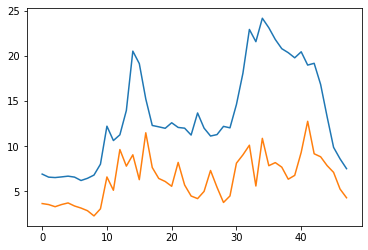

In [73]:
y = list(range(48))
plt.plot(y,F_i[:,9])
plt.plot(y,loads[h*(d-4):(d-3)*h])
plt.show

In [82]:
day = np.asarray(loads[161*h:161*h+h])
UpperBound = day + 3
LowerBound = day - 3
MidPoint = (UpperBound - LowerBound) / 2
A_peak = 2

day_F1 = np.zeros(48)

for i in range(h):
    if (day[i] - MidPoint[i]) > MidPoint[i]:
        day_F1[i] = (1-((UpperBound[i]-day[i])/(UpperBound[i]-MidPoint[i]))*A_peak)*day[i]
    else:
        day_F1[i] = (1-((MidPoint[i]-day[i])/(MidPoint[i]-LowerBound[i]))*A_peak)*day[i]


<function matplotlib.pyplot.show(close=None, block=None)>

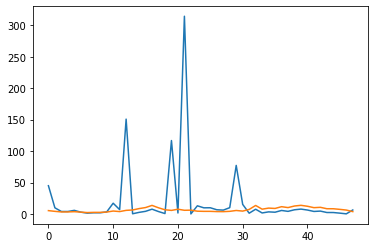

In [85]:
y = list(range(48))
plt.plot(y,day_F1)
plt.plot(y,day)
plt.show